In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('coded_final.csv')

In [2]:
corr = df.corr(numeric_only=True)
corr.style.background_gradient(cmap='coolwarm')

,RespondentID,How often do you travel by plane?,Do you ever recline your seat when you fly?,How tall are you?,Do you have any children under 18?,"In a row of three seats, who should get to use the two arm rests?","In a row of two seats, who should get to use the middle arm rest?",Who should have control over the window shade?,Is itrude to move to an unsold seat on a plane?,"Generally speaking, is it rude to say more than a few words tothe stranger sitting next to you on a plane?","On a 6 hour flight from NYC to LA, how many times is it acceptable to get up if you're not in an aisle seat?","Under normal circumstances, does a person who reclines their seat during a flight have any obligation to the person sitting behind them?",Is itrude to recline your seat on a plane?,"Given the opportunity, would you eliminate the possibility of reclining seats on planes entirely?",Is it rude to ask someone to switch seats with you in order to be closer to friends?,Is itrude to ask someone to switch seats with you in order to be closer to family?,Is it rude to wake a passenger up if you are trying to go to the bathroom?,Is itrude to wake a passenger up if you are trying to walk around?,"In general, is itrude to bring a baby on a plane?","In general, is it rude to knowingly bring unruly children on a plane?",Have you ever used personal electronics during take off or landing in violation of a flight attendant's direction?,Have you ever smoked a cigarette in an airplane bathroom when it was against the rules?,Gender,Age,Household Income,Education,Location (Census Region)
RespondentID,1.000000,-0.023381,-0.015843,0.196639,-0.023456,0.002181,0.084582,-0.067094,0.020626,0.039291,0.079399,0.038433,-0.046042,-0.015443,0.098018,0.041880,-0.048088,-0.030555,0.010996,0.001375,-0.031234,0.004689,-0.235772,0.041884,-0.053091,0.000841,-0.024051
How often do you travel by plane?,-0.023381,1.000000,0.009101,0.094117,0.013113,0.004502,0.047206,-0.019066,0.054381,0.036309,-0.009573,-0.053126,0.094729,0.052536,0.024273,0.059992,0.058407,-0.036459,0.041943,0.011189,0.185953,0.239679,-0.061481,-0.056094,0.136210,0.081325,-0.021962
Do you ever recline your seat when you fly?,-0.015843,0.009101,1.000000,-0.011401,-0.048938,0.037831,-0.010955,0.020696,0.068150,0.060910,0.077420,0.381455,0.513108,0.400085,0.036962,0.032201,0.005939,0.053522,-0.003998,0.001557,-0.121904,-0.058366,-0.019324,-0.063603,-0.016510,-0.011827,0.020478
How tall are you?,0.196639,0.094117,-0.011401,1.000000,0.035106,0.005087,0.038106,-0.040233,-0.012768,-0.002039,-0.050080,-0.009065,0.042558,0.081283,-0.042806,-0.034888,-0.105872,-0.045108,0.087030,0.072031,0.077784,0.081377,-0.679748,-0.006844,0.063610,0.048100,-0.042550
Do you have any children under 18?,-0.023456,0.013113,-0.048938,0.035106,1.000000,-0.019690,-0.032527,0.014361,-0.024507,-0.054422,-0.003803,-0.026285,-0.074951,-0.067708,0.005478,-0.027198,-0.004359,-0.001754,-0.158302,-0.209567,-0.038178,0.045583,-0.020169,-0.078049,0.088736,0.024374,-0.014672
"In a row of three seats, who should get to use the two arm rests?",0.002181,0.004502,0.037831,0.005087,-0.019690,1.000000,0.331769,0.095759,0.037101,0.003124,-0.001933,0.084303,-0.025160,0.030676,-0.040921,-0.063900,-0.102836,-0.020843,-0.074076,0.008563,-0.049967,-0.085739,-0.001309,0.105467,0.037550,0.011107,-0.009387
"In a row of two seats, who should get to use the middle arm rest?",0.084582,0.047206,-0.010955,0.038106,-0.032527,0.331769,1.000000,0.069248,0.020462,-0.004512,0.029634,0.100522,-0.020086,0.015280,-0.000285,-0.025027,-0.023147,0.030572,-0.020696,0.012708,0.007143,-0.013770,-0.046082,-0.015023,-0.016823,-0.008015,0.031208
Who should have control over the window shade?,-0.067094,-0.019066,0.020696,-0.040233,0.014361,0.095759,0.069248,1.000000,-0.022919,-0.042391,-0.072984,0.113683,-0.029392,-0.020709,-0.079486,-0.108101,-0.009005,-0.042100,-0.071028,-0.049473,-0.076139,-0.053927,0.030190,0.060303,0.038684,0.050865,0.011249
Is itrude to move to an unsold seat on a plane?

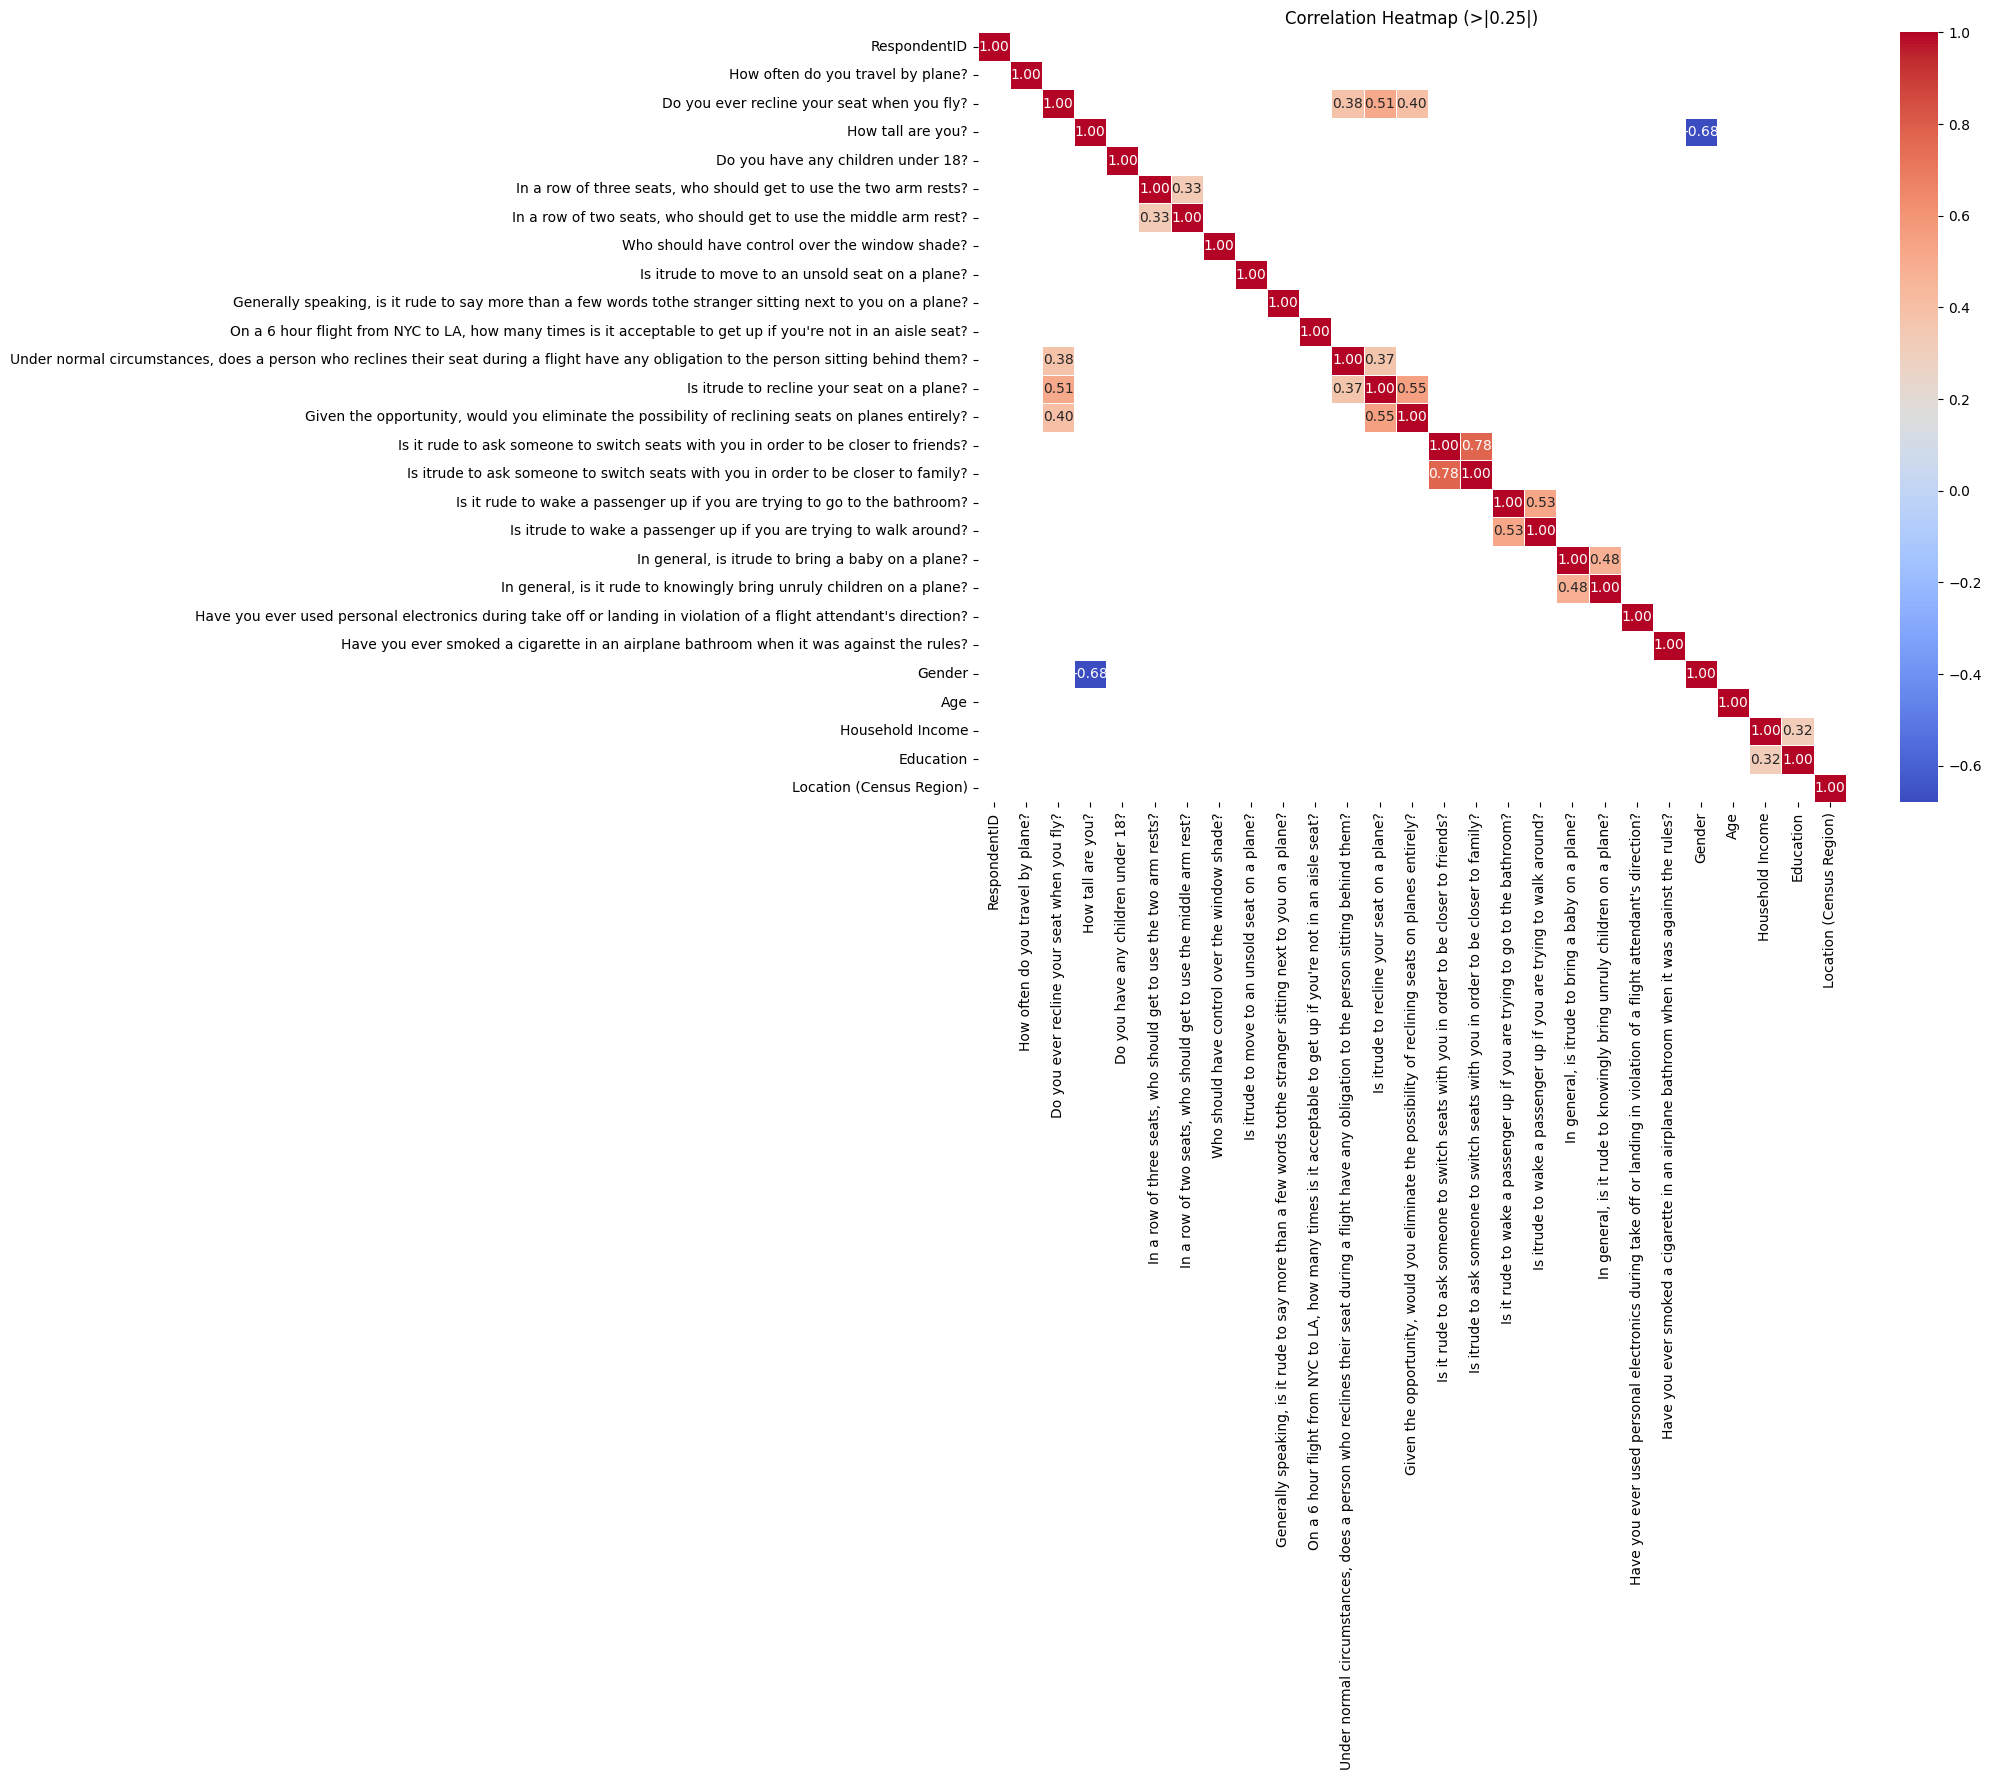

In [40]:
# Select correlations higher than 0.3 in absolute value
high_corr = corr[(corr > 0.25) | (corr < -0.25)]

# Create a heatmap of the selected correlations
plt.figure(figsize=(14, 10))
sns.heatmap(high_corr, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap (>|0.25|)')
plt.show()

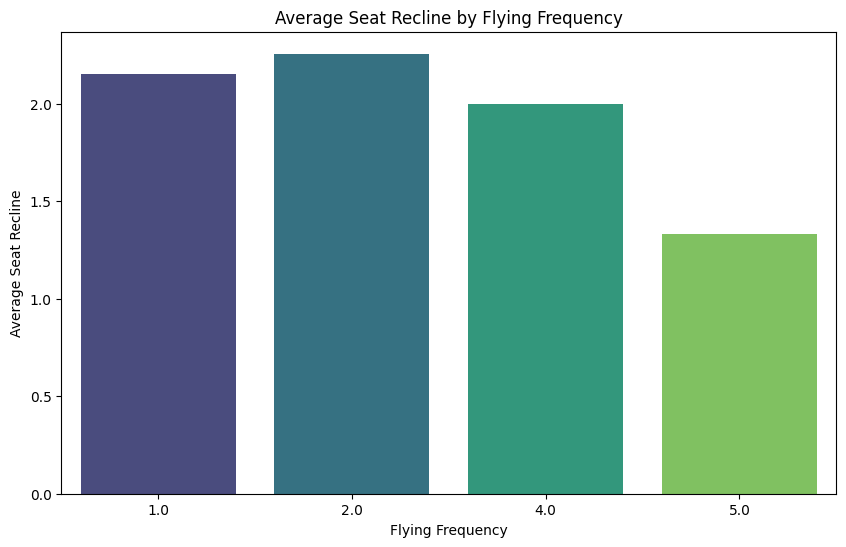

In [39]:
# Calculate average seat recline for each flying frequency
average_recline = df.groupby("How often do you travel by plane?")["Do you ever recline your seat when you fly?"].mean().reset_index()

# Visualizing the hypothesis with a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x="How often do you travel by plane?", y="Do you ever recline your seat when you fly?", data=average_recline, palette="viridis")

plt.title("Average Seat Recline by Flying Frequency")
plt.xlabel("Flying Frequency")
plt.ylabel("Average Seat Recline")

plt.show()

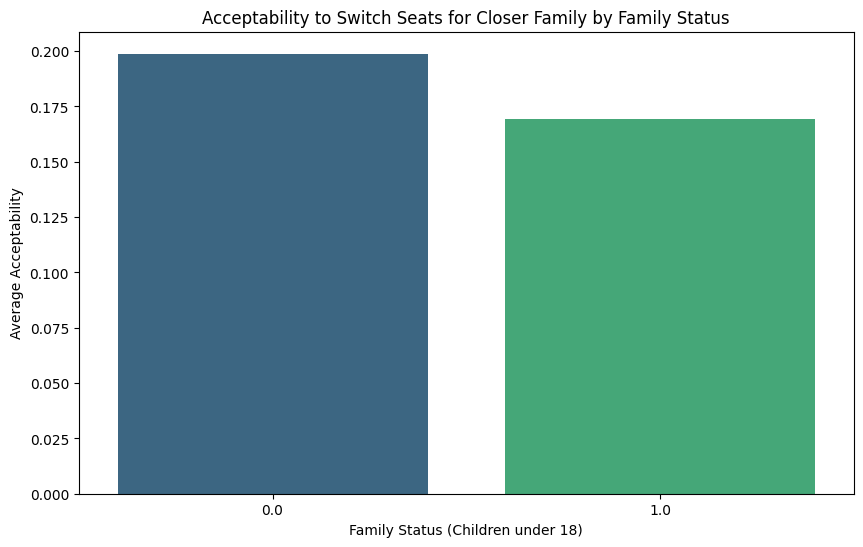

In [38]:
# Calculate average acceptability to switch seats for each family status
average_acceptability = df.groupby("Do you have any children under 18?")["Is itrude to ask someone to switch seats with you in order to be closer to family?"].mean().reset_index()

# Visualizing the hypothesis with a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x="Do you have any children under 18?", y="Is itrude to ask someone to switch seats with you in order to be closer to family?", data=average_acceptability, palette="viridis")

plt.title("Acceptability to Switch Seats for Closer Family by Family Status")
plt.xlabel("Family Status (Children under 18)")
plt.ylabel("Average Acceptability")

plt.show()

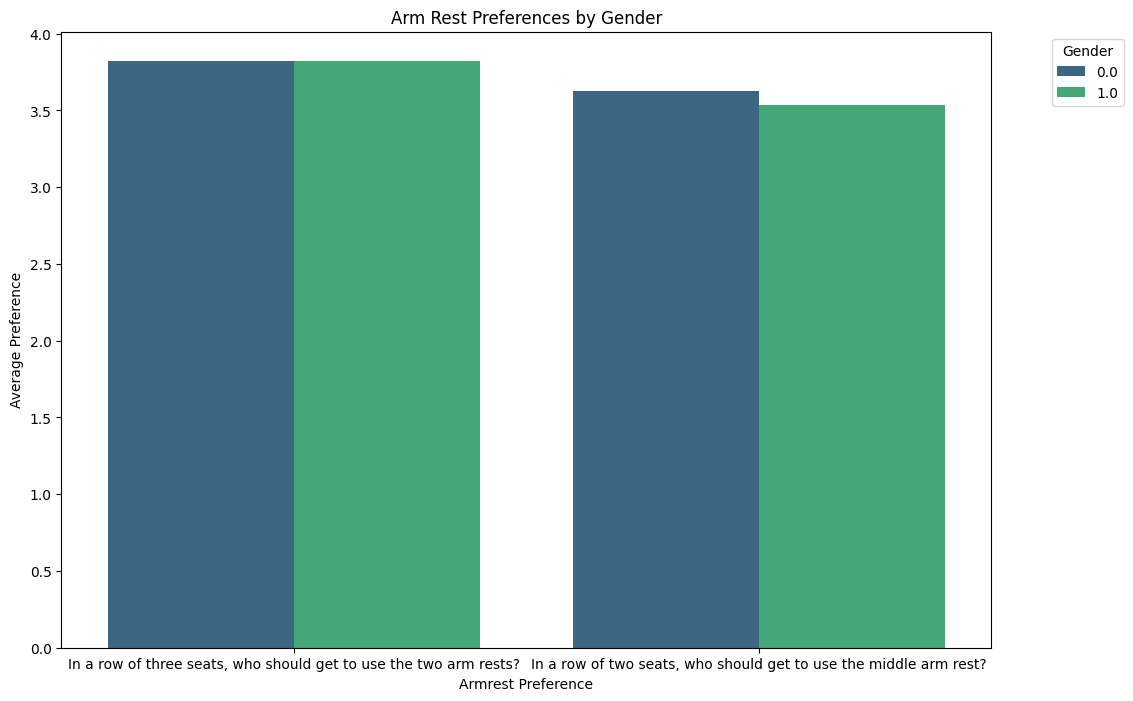

In [37]:
# Calculate average armrest preferences for each gender
average_armrest_preferences = df.groupby("Gender")[["In a row of three seats, who should get to use the two arm rests?", "In a row of two seats, who should get to use the middle arm rest?"]].mean().reset_index()

# Melt the DataFrame
melted_df = pd.melt(average_armrest_preferences, id_vars="Gender", var_name="Armrest Preference", value_name="Average Preference")

# Visualizing the hypothesis with a bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x="Armrest Preference", y="Average Preference", hue="Gender", data=melted_df, palette="viridis")

plt.title("Arm Rest Preferences by Gender")
plt.xlabel("Armrest Preference")
plt.ylabel("Average Preference")
plt.legend(title="Gender", loc="upper right", bbox_to_anchor=(1.15, 1))

plt.show()

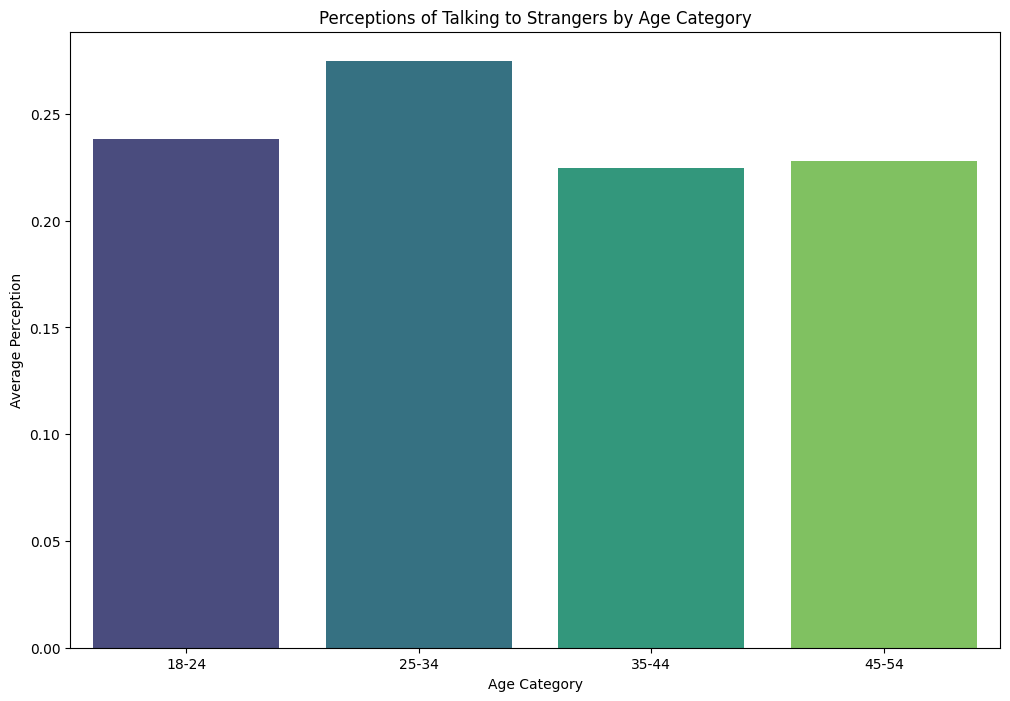

In [36]:
# Map age categories for better visualization
age_categories = {0.0: "18-24", 1.0: "25-34", 2.0: "35-44", 3.0: "45-54", 4.0: "55-64"}

df["Age Category"] = df["Age"].map(age_categories)

# Calculate average perception of talking to strangers for each age category
average_perception = df.groupby("Age Category")["Generally speaking, is it rude to say more than a few words tothe stranger sitting next to you on a plane?"].mean().reset_index()

# Visualizing the hypothesis with a bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x="Age Category", y="Generally speaking, is it rude to say more than a few words tothe stranger sitting next to you on a plane?", data=average_perception, palette="viridis")

plt.title("Perceptions of Talking to Strangers by Age Category")
plt.xlabel("Age Category")
plt.ylabel("Average Perception")

plt.show()